# Introduction to numerical robotics

This notebook is a general introduction to Pinocchio. It shows how to manipulate the geometry model of a robot manipulator: set the configuration, compute the position of the end effector, check for collisions or the distance to an obstacle. The main idea is to give a brief introduction of the general topic: how to discover and learn a robot movement constrained by the environment, using iterative optimization methods.


## Set up

Let us load the UR5 robot model, the Pinocchio library, some optimization functions from SciPy and the Matplotlib for plotting:

In [1]:
import pinocchio as pin
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
import time
import numpy as np
from numpy.linalg import inv,norm,pinv,svd,eig
from scipy.optimize import fmin_bfgs,fmin_slsqp
from utils.load_ur5_with_obstacles import load_ur5_with_obstacles,Target
import matplotlib.pylab as plt
from typing import List, Union

Let's first load the robot model and display it. For this tutorial, a single utility function will load the robot model and create obstacles around it:

In [2]:
robot = load_ur5_with_obstacles(reduced=True)


def endef(q):
    '''Return the 2d position of the end effector.'''
    pin.framesForwardKinematics(robot.model, robot.data, q)
    return robot.data.oMf[-1].translation[[0, 2]]

def coll(q):
    '''Return True if in collision, false otherwise.'''
    pin.updateGeometryPlacements(robot.model, robot.data, robot.collision_model, robot.collision_data, q)
    return pin.computeCollisions(robot.collision_model, robot.collision_data, False)

def distance_to_target(config, target):
    '''Return the distance between the end effector end the target (2d).'''
    difference = endef(config) - target
    distance = np.sqrt(np.dot(difference.T, difference))
    return distance

The next few lines initialize a 3D viewer.

In [3]:
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


The robot and the red obstacles are encoded in the `robot` object (we will not look in depth at what is inside this object). You can display a new configuration of the robot with `viz.display`. It takes a `numpy.array` of dimension 2 as input:

We also set up a target with is visualized as a green dot:
The `Target` object is the green dot that the robot should reach. 

You can change the target position by editing `target.position`, and display the new position with `target.display()`.

# Visualizing the moving robot
It is possible to move the robot with sliders and reach the target manually... 
- For instance, (-79°, 64°) seem like good angles for the 2 joints in the **configuration space**. 
- Visualized in the workspace, it seems like the end of the arm  is close to the target.

Note:
`viz` is an instance of `MeshcatVisualizer`, when using the `display(q=)` method -> *Display the robot at configuration q in the viewer by placing all the bodies* according to the docstring

In [4]:
from ipywidgets import interact
import ipywidgets as widgets

# adding the target in the workspace
target_pos = np.array([.5,.5])
target = Target(viz,position = target_pos)

config_q =np.zeros(2)
# moving the robot joints using sliders

def move_robot(joint_1, joint_2):
    global config_q
    config_q = np.array([np.deg2rad(joint_1), np.deg2rad(joint_2)])
    print(f"Joints configuration [radians] {config_q}")
    if coll(config_q):
        print('Collision')
    effector_location = endef(config_q)
    print(f"Robot effector located in the workspace at position \
        {effector_location[0]:.2f}, {effector_location[1]:.2f}")
    print(f"distance to target = {distance_to_target(config_q, target_pos):.2f}")
    viz.display(q=config_q)

interact(
    move_robot,
    joint_1=widgets.FloatSlider(min=-180, max=180, value=-79.),
    joint_2=widgets.FloatSlider(min=-180, max=180, value=64.)
);

hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

interactive(children=(FloatSlider(value=-79.0, description='joint_1', max=180.0, min=-180.0), FloatSlider(valu…

## Using the robot model
The robot is originally a 6 degrees-of-freedom (DOF) manipulator. Yet to make the example simple, we will only use its joints 1 and 2. The model has simply be loaded with "frozen" extra joints, which will then not appear in this notebook. Reload the model with `reduced=False` if you want to recover a model with full DOF.

The following function computes the position of the end effector (in 2d):

In [5]:
effector_location = endef(np.array([-1.37881011, 1.11701072]))
print(f"Robot effector located in the workspace at position \
{effector_location[0]:.2f}, {effector_location[1]:.2f}") # 0.48447545, 0.51644744 -> not far from the  (0.5, 0.5) target.

Robot effector located in the workspace at position 0.48, 0.52


This function checks if the robot is in collision, and returns `True` if a collision is detected.

In [6]:
coll(np.array([-1.37881011, 1.11701072])), coll(np.array([-0.77143553,  1.11701072])) # manually chosen 2 positions , first one is free, second one collides

(False, True)

The next function computes the distance between the end effector and the target.

Your code:

In [7]:
def dist(q):
     '''Return the distance between the end effector end the target (2d).'''
     difference = endef(q) - target_pos
     distance = np.sqrt(np.dot(difference.T, difference))
     return distance
dist(np.array([-1.37881011, 1.11701072]))


0.022617030708432108

Solution

In [8]:
%do_not_load tp0/generated/simple_path_planning_dist

UsageError: Line magic function `%do_not_load` not found.


## Random search of a valid configuration
The free space is difficult to represent explicitly. We can sample the configuration space until a free configuration is found:

In [9]:
def qrand(check=False) -> np.ndarray:
    '''Return a random configuration. If `check` is True, this configuration is not is collision.'''
    q = np.deg2rad(-180. + 360.*np.random.rand(2))
    if check:
        while coll(q):
            q = np.deg2rad(-180. + 360.*np.random.rand(2))
    if check:
        assert not coll(q)
    return q
qrand(check=True)

array([-1.51445058, -2.96777205])

The solution if needed:

In [10]:
%do_not_load tp0/generated/simple_path_planning_qrand

UsageError: Line magic function `%do_not_load` not found.


In [11]:
viz.display(qrand(check=True))

Let's now find a valid configuration that is arbitrarily close to the target: sample until dist is small enough and coll is false (you may want to display the random trials inside the loop).

## From a random configuration to the target
Let' s now start from a random configuration. How can we find a path that bring the robot toward the target without touching the obstacles. Any idea?


-> **Idea**: alternate (with a probability between descent toward the target & pure random step) This would lead to a bit more "curiosity" and maybe avoiding to stay stuck.

In [12]:
bool(np.random.binomial(1, 0, 1).flatten())


False

In [13]:
# Random descent: crawling from one free configuration to the target with random
# steps.
def randomDescent(
          q0 = None,
          default_step=0.1,
          max_iteration: int =2000,
          isotropic: bool =False,
          descend_toward_target:  bool =True,
          live_refresh:  bool=False,
          discovery_probability=0
     ) -> List[np.ndarray]:
     '''
     Make a random walk of default_step step toward target (if descend_toward_target)
     Return the list of visited configurations 
     - isotropic: False by default . Sample x & y in {-1; +1} step
     - descend_toward_target: 
          - True by default. Take a step only if the distance decreases. Otherwise try again another random direction.
          - If False, we just perform a True random walk.
               - The trajectories allow discovery as they're not trying to go toward the target using the shortest path direction.
               - We do not enforce the robot arm to try to go toward the target
               so it may very well never reach the target in a small fixed number of iterations, even if it started next to it.
     - live_refresh: for debug purpose and visualize the robot moves during the random walk
     
     - discovery_probability:(between 0 & 1).
          - When 0, it is similar to having `descend_toward_target=True`.
          - When 1, it is similar to having `descend_toward_target=False` which means a totally random walk.
     Idea: alternate (with a probability between descent toward the target & pure random step)
     This would lead to a bit more curiosity.
     A simple way to implement the idea would be to set the descend_toward_target boolean 
     based on a Bernoulli distribution sampling. 
     '''
     q = qrand(check=True) if q0 is None else q0
     hist = [ q.copy() ]
     success = False
     distance = dist(q)
     iter = 0
     failure_count = 0
     step = default_step
     descend_toward_target_local = descend_toward_target
     while distance>0.01:
          if discovery_probability is not None:
               descend_toward_target_local = bool(np.random.binomial(1, 1-discovery_probability, 1).flatten())
          if iter>max_iteration:
               break
          success = True
          # We sample the orientation randomly:
          # Even when descend_toward_target=True, we do not look for the steepest direction toward the target.
          if isotropic: # isotropic sampling (similar to sampling a uniform orientation on [-180, 180°])
               unit_random = np.random.rand(2)-0.5
               unit_random_norm = np.sqrt(np.dot(unit_random.T, unit_random))
               if unit_random_norm!=0.:
                    unit_random /= unit_random_norm          
               new_config = q + unit_random*step
          else: # grid steps (horizontal {-1, +1}, vertical {-1, +1})
               random_signs = np.random.randint(0, 2, size=2)*2-1 #[-1 or +1]
               new_config = q + step*random_signs
          new_config = np.mod((new_config)+np.pi, 2*np.pi)-np.pi
          new_distance = dist(new_config)
          if coll(new_config):
               success = False
          elif descend_toward_target_local and (new_distance > distance): # A step is made in case the distance to target decreases
               success = False
          if success:
               q = new_config
               distance = new_distance
               failure_count=0 # reset
               step = default_step
               hist.append(q)
               if live_refresh>0:
                    if len(hist)%live_refresh ==0:
                         viz.display(q)
          else:
               # In case we get stuck for too long, we can decrease the step...
               failure_count+=1
               if failure_count>10:
                    step = default_step/failure_count
                    # print("reduce step")
          iter+=1
     return hist


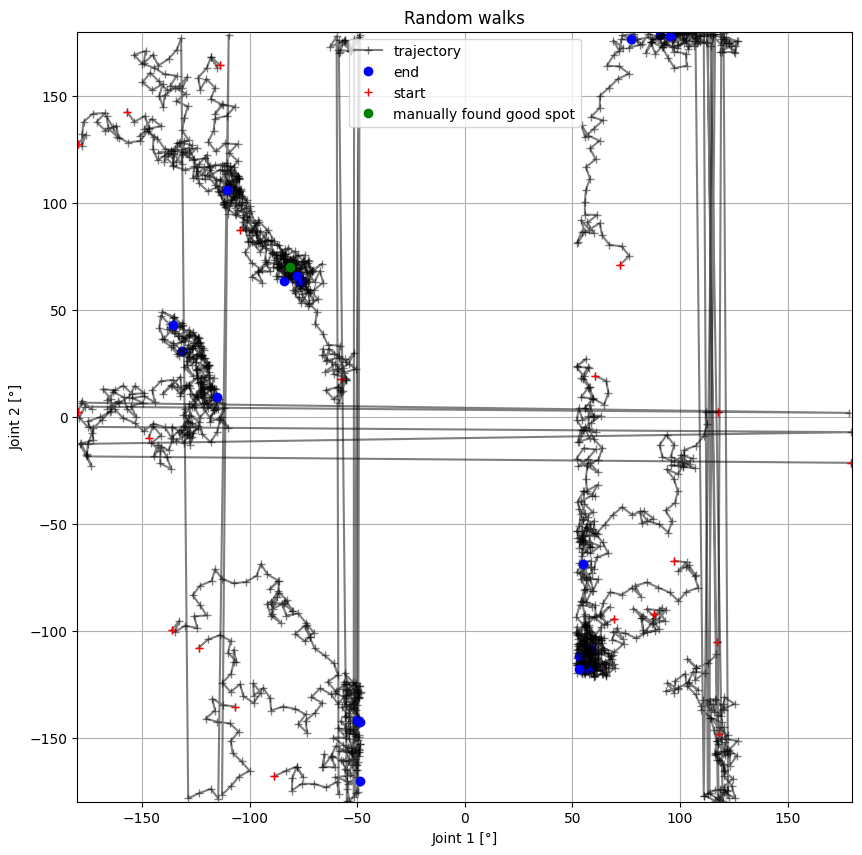

In [40]:
num_walks, max_iteration = 20, 200
# num_walks, max_iteration = 2000, 300
plt.figure(figsize=(10,10))
walk_trajectories = []
for i in range(num_walks):
     walk_trajectory = randomDescent(
          default_step=0.1,
          max_iteration=max_iteration,
          live_refresh=False,
          isotropic=True,
          discovery_probability=0.3,
     )
     walk_trajectories.append(np.array(walk_trajectory))
     # viz.display(walk_trajectory[-1])
     traj = np.rad2deg(np.array(walk_trajectory))
     plt.plot(traj[:, 0], traj[:, 1], "k-+", alpha=0.5, label="trajectory" if i==0 else None)
     plt.plot(traj[-1, 0], traj[-1, 1], "bo", label="end" if i==0 else None)
     plt.plot(traj[0, 0], traj[0, 1], "r+", label="start" if i==0 else None)
plt.xlim(-180., 180.)
plt.ylim(-180., 180.)
plt.xlabel("Joint 1 [°]")
plt.ylabel("Joint 2 [°]")
plt.plot([-81.], [70.], "go", label="manually found good spot")
plt.title("Random walks")
plt.legend()
plt.grid()
plt.show()
# See the next section to get the trajectories overlayed on the configuration space visualizations

And solution if needed

In [15]:
%do_not_load tp0/generated/simple_path_planning_random_descent

UsageError: Line magic function `%do_not_load` not found.


In [16]:
q0= np.deg2rad([-90., 40.])
totally_random = np.array(randomDescent(q0 = q0, default_step=0.1, max_iteration=1000, isotropic=True, live_refresh=10, descend_toward_target=False))

## Configuration space
Let's try to have a better look of the configuration space. In this case, it is easy, as it is dimension 2: we can sample it exhaustively and plot it in 2D. For that, let's introduce another function to compute the distance to collision:

In [17]:
def collisionDistance(q):
     '''Return the minimal distance between robot and environment. '''
     pin.updateGeometryPlacements(robot.model,robot.data,robot.collision_model,robot.collision_data,q)
     if pin.computeCollisions(robot.collision_model,robot.collision_data,False):
         return 0.0
     idx = pin.computeDistances(robot.collision_model,robot.collision_data)
     return robot.collision_data.distanceResults[idx].min_distance

Now, let's sample the configuration space and plot the distance-to-target and the distance-to-obstacle field (I put 500 samples to spare your CPU, but you need at least 10x more for obtaining a good picture).

In [37]:
def sampleSpace(nbSamples=500, prevent_collisions=False):
     '''
     Sample nbSamples configurations and store them in two lists depending
     if the configuration is in free space (hfree) or in collision (hcol), along
     with the distance to the target and the distance to the obstacles.
     '''
     hcol = []
     hfree = []
     for i in range(nbSamples):
          q = qrand(prevent_collisions)
          if not coll(q):
               hfree.append( list(q.flat) + [ dist(q), collisionDistance(q) ])
          else:
               hcol.append(  list(q.flat) + [ dist(q), 1e-2 ])
     return hcol,hfree

def plotConfigurationSpace(hcol, hfree,markerSize=20, legend=False, trajectories=None):
     '''
     Plot 2 "scatter" plots: the first one plot the distance to the target for 
     each configuration, the second plots the distance to the obstacles (axis q1,q2, 
     distance in the color space).
     '''
     htotal = hcol + hfree
     h=np.array(htotal)
     plt.figure(figsize=(5, 10))
     plt.subplot(2,1,1)
     plt.scatter(h[:,0],h[:,1],c=h[:,2],s=markerSize,lw=0)
     plt.title("Distance to the target")
     plt.colorbar()
     if trajectories is not None:
          for trajectory in trajectories:
               plt.plot(trajectory[:, 0], trajectory[:, 1], "r-+", lw=3)
     plt.plot(np.array([-1.37881]), np.array([1.11701]), "co", label="Manually found sweet spot")
     if legend:
          plt.legend()
     plt.subplot(2,1,2)
     plt.scatter(h[:,0],h[:,1],c=h[:,3],s=markerSize,lw=0)
     if trajectories is not None:
          for trajectory in trajectories:
               plt.plot(trajectory[:, 0], trajectory[:, 1], "r-+", lw=3)
     plt.title("Distance to the obstacles")
     plt.colorbar()
     plt.plot(np.array([-1.37881]), np.array([1.11701]), "ro", label="Manually found sweet spot")
     # plt.show()

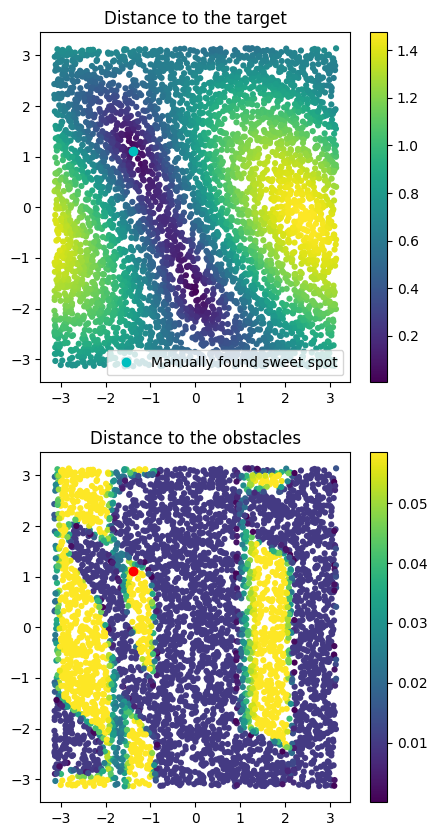

In [38]:
hcol,hfree = sampleSpace(5000)
plotConfigurationSpace(hcol,hfree, legend=True)


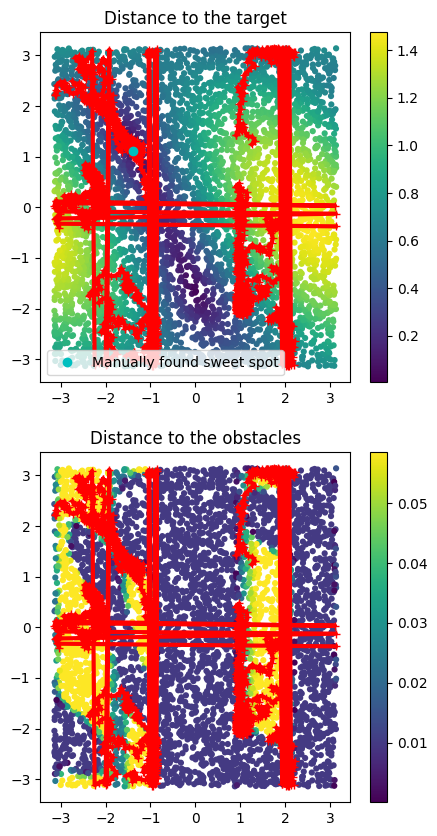

In [42]:
plotConfigurationSpace(hcol,hfree, legend=True, trajectories=walk_trajectories[:])

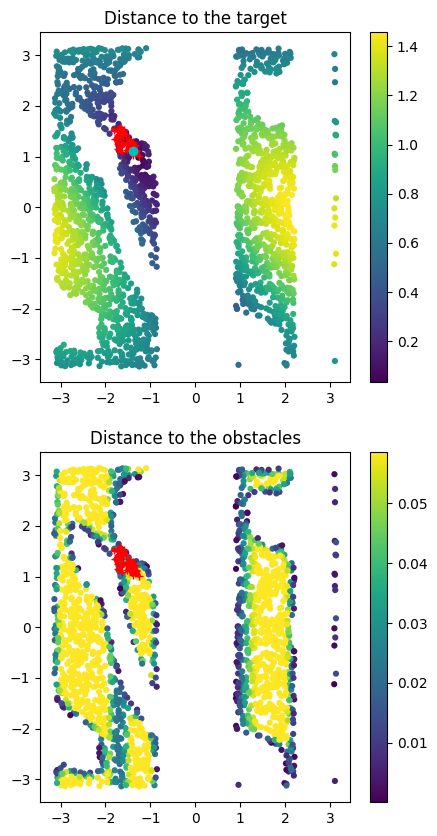

In [46]:
hcol,hfree = sampleSpace(2000, prevent_collisions=True)
plotConfigurationSpace(hcol,hfree, trajectories=walk_trajectories[2:3])

You can try to match your representation of the free space of the robot with this plot. 
As an example, you can display on this plot a feasible trajectory discover by random walk from an init position.

In [23]:
### PLEASE SEE ABOVE
qinit = np.array([-1.1, -3. ])

Here is a solution:

In [24]:
%do_not_load tp0/generated/simple_path_planning_traj

UsageError: Line magic function `%do_not_load` not found.


## Optimize the distance under non-collision constraint
Finally, let's use one of the optimizers from SciPy to search for a robot configuration that minimizes the distance to the target, under the constraint that the distance to collision is positive.
For that, we define a *cost function* $cost: \mathcal{C} \to \mathbb{R}$ (taking the robot configuration and returning a scalar) and a constraint function (taking again the robot configuration and returning a scalar or a vector of scalar that should be positive). We additionally use the "callback" functionnality of the solver to render the robot configuration corresponding to the current value of the decision variable inside the solver algorithm.
We use the "SLSQP" solver from SciPy, which implements a "sequential quadratic program" algorithm and accepts constraints.


Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.496914067014994e-07
            Iterations: 29
            Function evaluations: 108
            Gradient evaluations: 29
[-1.34173265  1.11253533]
return code: 0


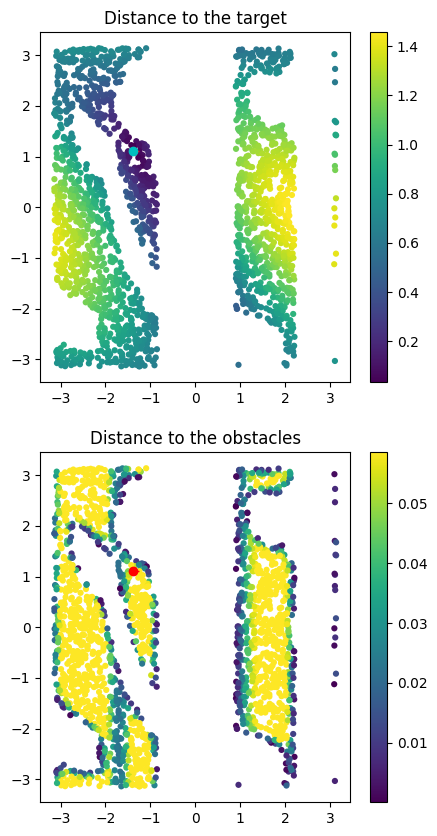

In [50]:
def cost(q):
     return dist(q)


def constraint(q):
     dista = collisionDistance(q)
     return -100. if dista<=0.0001 else dista # 0 is an accepted solution

def callback(q):
     '''
     At each optimization step, display the robot configuration in gepetto-viewer.
     '''
     q= np.mod(q + np.pi, 2*np.pi) - np.pi
     global optim_trajectory
     optim_trajectory.append(q) 
     viz.display(q)
     # time.sleep(.01)

def optimize(q0):
     '''
     Optimize from an initial random configuration to discover a collision-free
     configuration as close as possible to the target.
     USE fmin_slsqp, see doc online
     '''
     bounds = None  # it is prefereable to let the configuration in the unbounded 2D plane and to apply the modulo for visualization purposes
     # bounds=[(-np.pi, np.pi), (-np.pi, np.pi)]

     ret, _, _, imode, _= fmin_slsqp(
          cost, x0=q0,
          f_ieqcons=constraint, callback=callback, bounds=bounds, full_output=True
     )
     ret= np.mod(np.array(ret) + np.pi, 2*np.pi) - np.pi
     # print("return:", ret)
     return imode, ret
optim_trajectory = []
# qinit = np.array([-1.1, -3.])
# qinit = np.array([-2.5, -1]) #NOK
# qinit = np.array([-1.5, 0.])
qinit = np.array([-1.5, -1.]) #OK

return_code, q_solution = optimize(qinit)

print(q_solution)
optim_trajectory = [np.array([q_solution])]
plotConfigurationSpace(hcol,hfree, trajectories=optim_trajectory)
print("return code:", return_code)

Here is a valid solution:

In [26]:
%do_not_load tp0/generated/simple_path_planning_optim

UsageError: Line magic function `%do_not_load` not found.


Look at the output of the solver. It always returns a variable value, but sometimes the algorithm fails being traped in an unfeasible region. Most of the time, the solver converges to a local minimum where the final distance to the target is nonzero

Now you can write a planner that try to optimize and retry until a valid solition is found!

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4166752524791795
            Iterations: 34
            Function evaluations: 152
            Gradient evaluations: 34
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4166751978982772
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.41667499281206494
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.41667493859736304
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4166749180887366
            Iterations: 1
            Function evaluat

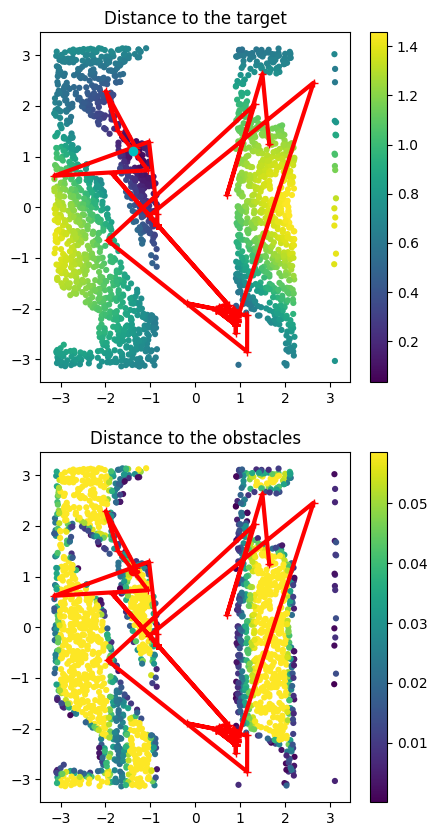

In [60]:
def planner(qinit=None):
    """Find a solution which mimizes the cost function (distance) under collision constraints
    up until a solution is found which satisfies a solution.
    This helps the optimizer to get out of locations where it is stuck
    """
    q_solution = qinit
    return_code = 1
    while return_code!=0 or dist(q_solution)>0.01: # restart as much as you want until you reach a correct solution which has a low distance to the target
        if q_solution is None:
            q_solution = qrand(check=True)  # start from a feasible random position
        return_code, q_solution = optimize(q_solution)
    return q_solution
optim_trajectory=[]
final_q = planner()
optim_trajectory = np.array([optim_trajectory])
optim_trajectory= np.mod(np.array(optim_trajectory) + np.pi, 2*np.pi) - np.pi
plotConfigurationSpace(hcol,hfree, trajectories=optim_trajectory)
assert not coll(final_q)
assert  dist(final_q)<1.E-5


And the solution if you need it:

In [ ]:
%do_not_load tp0/generated/simple_path_planning_useit